## Notebook to calculate monthly authorized users

This notebook calculates month authorized users based on history of /v1 and /v2 messages retrieved through the /logs API. The count is for all workspaces and/or skills for one service instance of Assistant. To use, we need the `APIKEY` and `assistant_url` values from the settings of one of the Assistants or Skills. We're only using the URL up to the instance ID, so the URLs and API keys are the same. You can set them in the next cell, or set these values to `''` and be prompted when the notebook runs. You can also get a flattened log output in CSV format by specifying `EXPORT_FILE_PATH` in the cell below or when prompted.

In [ ]:
APIKEY = 'uPmRXh***********************AZJ6Hu'
assistant_url = 'https://api.us-east.assistant.watson.cloud.ibm.com/instances/96a44bf2-df75-4683-852d-1187573b8948'
EXPORT_FILE_PATH = 'authorized_user_logs.csv'

In [10]:
import string
import re
import os
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
if APIKEY is None or len(APIKEY) == 0:
    APIKEY = input("Enter Assistant API key")
if assistant_url is None or len(assistant_url) == 0:
    assistant_url = input("Enter assistant or skill /v1 or /v2 API URL")
if EXPORT_FILE_PATH is None or len(EXPORT_FILE_PATH) == 0:
    EXPORT_FILE_PATH = input("Enter path of the file for CSV output.")
api_regex = r'https:\/\/api..*.com\/instances\/([a-zA-Z0-9]|-)+'
API_URL = re.search(api_regex, assistant_url).group()

http_headers = {'Content-Type': 'application/json',
                'Accept': 'application/json'}
auth = ('APIKEY', APIKEY)
API_VERSION = '2020-04-01'
LOGS_API = '/v1/workspaces/%s/logs?version=%s'
WORKSPACES_API = '/v1/workspaces?version=%s'


In [12]:
"""
This routine returns all the logs in JSON (/v1 and /v2 message calls) for all work spaces for a given
service instance of Watson Assistant. 
"""

def get_all_logs():
    # Get all the workspaces
    workspaces_url = API_URL + WORKSPACES_API % API_VERSION
    response = requests.get(workspaces_url, auth=auth, headers=http_headers)
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(response.content)

    # Now retrieve the logs for each of the workspaces
    all_logs = []
    count = 1
    workspaces = results['workspaces']
    for workspace in workspaces:
        done = False
        logs_url = API_URL + LOGS_API % (workspace['workspace_id'], API_VERSION)
        # Continue retrieving logs until there are no more pages of logs
        while not done:
            response = requests.get(logs_url, auth=auth, headers=http_headers)
            if response.status_code == 200:
                results = response.json()
                all_logs += results['logs']
                print('Retrieved %s log entries from workspace \'%s\'.' % (len(results['logs']), workspace['workspace_id']))
                next_page = results.get('pagination')
                if len(next_page) > 0:
                    logs_url = API_URL + next_page['next_url']
                else:
                    done = True
            else:
                raise Exception(response.content)
        print('Finished %s of %s workspaces.' % (count, len(workspaces)))
        count += 1
    return all_logs

In [13]:
"""
This routine processes the /logs JSON to generate a flatter data structure without PI for further processing:
 
    'user_detail':
        - request_timestamp - time when the /message call was made
        - authorized_user - string used to determine who the user is
        - type - how the 'authorized_user' value was determined; by field 'user_id', 'session_id' or 'conversation_id'
        - dialog_turn_counter' - what turn of the conversation this /message call represents
        - text_length - length of the input utterance; 0 if none
        - workspace_id - workspace of this /message request

Based on this detail, this routine also calculates unique users by month and lists of the ids of those users by
month.

    'unique_authorized_users_by_month': 
        {'month1': {'Fred', 'Barney', 'Wilma'', Betty', 'Bam Bam'},
        'month2': {'Rocky', 'Bullwinkle', 'Natasha'},
        'month3': {'Gilligan', 'Skipper', 'Professor', 'Ginger, 'Maryann'}
        }
        
    'authorized_user_counts_by_month': 
        {'user_id': 
            {'month1': total, 'month2': total, 'month3': total}, 
        'session_id': 
            {'month2': total, 'month2': total, 'month3': total}, 
        'conversation_id': 
            {'month3': total, 'month2': total, 'month3': total}}
"""

def calculate_authorized_users(logs):

    def log_sort_function(i):
        return str(i['request_timestamp'])

    # First, sort the logs so the graph plotting is easier
    logs.sort(key=log_sort_function)

    user_detail = []
    unique_authorized_users_by_month = {}
    authorized_user_counts_by_month = {'user_id': {}, 'session_id': {}, 'conversation_id': {}}

    for entry in logs:
        # Get the authorized user id based on what fields in the /message payload were set. In priority
        # order, user_id, session_id, conversation_id.
        user_id = entry['request'].get('user_id')
        if user_id is not None:
            # user_id is set so record this value as the authorized user. This is the same for
            # both /v1/message and /v2/message
            type = 'user_id'
        else:
            user_id = entry['response']['context']['system'].get('session_id')
            if user_id is not None:
                # if we can't find user_id, the look for the substitute. If we fine session_id
                # it means this is a /v2/message call, use it.
                type = 'session_id'
            else:
                # otherwise, user conversation_id. Both /v1/message and /v2/message
                user_id = entry['response']['context']['conversation_id']
                type = 'conversation_id'

        # Get the utterance text if there is input. We're getting this solely to get its length. For
        # privacy reasons, we are saving on the length to indicate if there was input.
        utterance_text = ''
        input = entry['request'].get('input')
        if input is not None:
            input_text = input.get('text')
            if input_text is not None:
                utterance_text = input_text

        # Write the flatter log record. This is what will be written as output to a CSV file for
        # futher analysis
        new_entry = {'request_timestamp': datetime.datetime.strptime(entry['request_timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ'),
                            'authorized_user': user_id,
                            'type': type,
                            'dialog_turn': int(entry['response']['context']['system']['dialog_turn_counter']),
                            'text_length': len(utterance_text),
                            'workspace_id': entry['workspace_id']}
        user_detail.append(new_entry)

        # Now, add this as an authorized user if there is text input or we are past the first turn of the dialog.
        # Conversely, do not add this as an authorized user if there is no text input and we are on the first
        # turn of the dialog.
        if new_entry['dialog_turn'] > 1 or new_entry['text_length'] > 0:
            month = new_entry['request_timestamp'].strftime("%b")
            if month not in unique_authorized_users_by_month.keys():
                unique_authorized_users_by_month[month] = set()
                authorized_user_counts_by_month['user_id'][month] = 0
                authorized_user_counts_by_month['conversation_id'][month] = 0
                authorized_user_counts_by_month['session_id'][month] = 0
            if new_entry['authorized_user'] not in unique_authorized_users_by_month[month]:
                unique_authorized_users_by_month[month].add(new_entry['authorized_user'])
                authorized_user_counts_by_month[new_entry['type']][month] += 1

    return user_detail, authorized_user_counts_by_month, unique_authorized_users_by_month

In [14]:
all_logs = get_all_logs()
user_detail, authorized_user_counts_by_month, unique_authorized_users_by_month = calculate_authorized_users(all_logs)

Retrieved 7 log entries from workspace 'bbd0fd16-5b74-45eb-92b4-8070ff1e0d1a'.
Finished 1 of 2 workspaces.
Retrieved 100 log entries from workspace '9db4b84c-e573-428a-b01c-52193e9db275'.
Retrieved 100 log entries from workspace '9db4b84c-e573-428a-b01c-52193e9db275'.
Retrieved 100 log entries from workspace '9db4b84c-e573-428a-b01c-52193e9db275'.
Retrieved 46 log entries from workspace '9db4b84c-e573-428a-b01c-52193e9db275'.
Finished 2 of 2 workspaces.


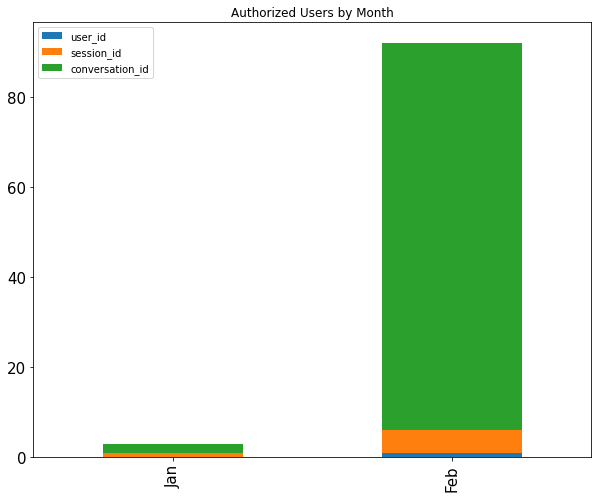

,user_id,session_id,conversation_id,Total
Jan,0,1,2,3
Feb,1,5,86,92
Total,1,6,88,95


In [26]:
user_count_df = pd.DataFrame(authorized_user_counts_by_month)
user_count_df.plot.bar(stacked=True, figsize=(10, 8), title='Authorized Users by Month', fontsize=15) 
# plt.title('Authorized Users by Month')
plt.show()

user_count_df.loc["Total"] = user_count_df.sum(axis=0)
user_count_df.loc[:, "Total"] = user_count_df.sum(axis=1)
user_count_df = user_count_df.style.set_properties(**{'font-size': '12pt',})
user_count_df

In [27]:
detail_df = pd.DataFrame(user_detail)
if EXPORT_FILE_PATH is not None and len(EXPORT_FILE_PATH) > 0:
    detail_df.to_csv(EXPORT_FILE_PATH)

In [28]:
detail_df

,request_timestamp,authorized_user,type,dialog_turn,text_length,workspace_id
0,2021-01-26 15:00:31.022,43ab9843-4eb3-4f77-b100-86545249f95b,session_id,1,0,bbd0fd16-5b74-45eb-92b4-8070ff1e0d1a
1,2021-01-26 15:00:37.545,43ab9843-4eb3-4f77-b100-86545249f95b,session_id,2,2,bbd0fd16-5b74-45eb-92b4-8070ff1e0d1a
2,2021-01-26 15:00:51.558,e89e9083-0b30-4cf5-9d8c-069987186bbb,session_id,1,0,bbd0fd16-5b74-45eb-92b4-8070ff1e0d1a
3,2021-01-30 01:54:49.735,7ead83ea-72d4-4090-803b-e84eb37e227f,conversation_id,1,0,9db4b84c-e573-428a-b01c-52193e9db275
4,2021-01-31 03:46:12.734,c3102879-6805-43b3-b43f-d116ecf26bd7,conversation_id,1,0,9db4b84c-e573-428a-b01c-52193e9db275
...,...,...,...,...,...,...
348,2021-02-19 16:48:21.648,9f406033-1a18-44d9-9192-f51d7fec541e,session_id,1,0,bbd0fd16-5b74-45eb-92b4-8070ff1e0d1a
349,2021-02-19 16:48:29.644,3484ad12-33c7-4c25-805d-355ab8b14a6b,session_id,1,0,bbd0fd16-5b74-45eb-92b4-8070ff1e0d1a
350,2021-02-19 16:48:36.699,3484ad12-33c7-4c25-805d-355ab8b14a6b,session_id,2,21,bbd0fd16-5b74-45eb-92b4-8070ff1e0d1a
351,2021-02-19 19:58:02.818,1159e766-5531-4cab-a104-f85f50782dc3,session_id,1,12,bbd0fd16-5b74-45eb-92b4-8070ff1e0d1a
